In [1]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from statistics import median, mean
from matplotlib import pyplot as plt
import numpy as np
import json
from tqdm import tqdm
from glob import glob
import os
import sys
sys.path.insert(0,"/study/mrphys/skunkworks/kk/mriUnet")
from fullmodel import fullModel
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.model_selection import KFold as kf
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from mriDataset import mriSliceDataset
from smoothing import GaussianSmoothing

In [2]:
# Dataset
T1path = sorted(glob('/study/mrphys/skunkworks/training_data/mover01/*/processed_data/T1_3_tv.nii'))
samples = [p.split('/')[6] for p in T1path]
class FullDataset(Dataset):   
    def __getitem__(self, index):
        if index<256:
            return self.xgt[:,index,:,:], self.ymask[:,index,:,:]
        elif index<512:
            index = index-256
            return self.xgt[:,:,index,:], self.ymask[:,:,index,:]
        else:
            index = index-512
            return self.xgt[:,:,:,index], self.ymask[:,:,:,index]
    def __len__(self):
        return 768

In [3]:
folds = {}
kfsplitter = kf(n_splits=5, shuffle=True, random_state=69420)
for i, (train_index, test_index) in enumerate(kfsplitter.split(samples[0:65])):
    folds[i+1] = test_index
    print(f'Fold #{i+1} : {test_index}')

Fold #1 : [ 4  7 13 16 20 21 24 31 37 40 42 56 61]
Fold #2 : [ 3  5  8 25 26 35 43 47 49 51 60 62 63]
Fold #3 : [ 6 12 17 18 19 28 32 34 36 45 48 50 58]
Fold #4 : [ 0  1  2  9 11 14 23 27 29 33 39 52 54]
Fold #5 : [10 15 22 30 38 41 44 46 53 55 57 59 64]


In [36]:
def complexnoise(shape, std=0.5):
    return torch.randn(shape)*std + 1J*torch.randn(shape)*std

def stack(slicedArray):
    X = slicedArray[0:256]
    Y = slicedArray[256:512]
    Z = slicedArray[512:768]
    X, Y, Z = np.vstack(X).transpose(1,0,2,3), np.vstack(Y).transpose(1,2,0,3), np.vstack(Z).transpose(1,2,3,0)
    return (X+Y+Z)/3

def prediction(model, dataset):
    model.eval()
    predictions = {
        "2 mins pca (gt)":[],
        "9 mins pca (gt)":[],
        "Denoised pca (pred)":[],
        "9 minutes T1 (pred)":[],
        "Denoised T1 (pred)":[],
        "T1 (gt)":[],
        "mask (gt)":[],
        "Denoised mask (pred)":[],
        "9 minutes mask (pred)":[],
    }
    for i, data in tqdm(enumerate(dataset)):
        xgt, ymask = data
        x = torch.tensor(xgt).unsqueeze(0)[:,0:10].to(model.device)
        gt = torch.tensor(xgt).unsqueeze(0)[:,10:20].to(model.device)
        y = torch.tensor(ymask).unsqueeze(0)[:,0:1].to(model.device)
        mask = torch.tensor(ymask).unsqueeze(0)[:,1:2].to(model.device)
        x = gt*(1+complexnoise(gt.shape).to(model.device))
        # x - 2 mins pca
        # gt - 9 mins pca
        # y - t1 mapping
        # mask - 0,1,2,3 -> bkg,csf,wm,gm
        with torch.no_grad():
            preds, losses, loss = model(x, gt, y, mask.clone())
            denoised_x, y_pred_denoised, y_pred_gt, denoised_mask_logit, gt_mask_logit = preds
            addToDict = {
                "2 mins pca (gt)":x.cpu().numpy(),
                "9 mins pca (gt)":gt.cpu().numpy(),
                "Denoised pca (pred)":denoised_x.cpu().numpy(),
                "9 minutes T1 (pred)":y_pred_gt.cpu().numpy(),
                "Denoised T1 (pred)":y_pred_denoised.cpu().numpy(),
                "T1 (gt)":y.cpu().numpy(),
                "mask (gt)":mask.cpu().numpy(),
                "Denoised mask (pred)":torch.sigmoid(denoised_mask_logit).cpu().numpy(),
                "9 minutes mask (pred)":torch.sigmoid(gt_mask_logit).cpu().numpy(),
            }
            for key in addToDict.keys():
                predictions[key].append(addToDict[key])
                
    for key in predictions.keys():
        predictions[key] = stack(predictions[key])
                   
    return predictions

In [37]:
fold = 1
gpu_id = 5
name = f"fullModel_{fold}"

model = fullModel().to(gpu_id)
model.load_state_dict(torch.load(f'/study/mrphys/skunkworks/kk/outputs/{name}/weights/{name}_BEST.pth'))
model.device = gpu_id

index = folds[fold][0]
with open(f'/scratch/mrphys/pickled/fullDataset_{index}.pickle', 'rb') as f:
    dataset = pickle.load(f)

In [38]:
predictions = prediction(model, dataset)

768it [01:13, 10.39it/s]


In [39]:
# unpack
acc = predictions["2 mins pca (gt)"]
full = predictions["9 mins pca (gt)"]
denoised = predictions["Denoised pca (pred)"]
T1_full = predictions["9 minutes T1 (pred)"]
T1_denoised = predictions["Denoised T1 (pred)"]
T1_gt = predictions["T1 (gt)"]
mask = predictions["mask (gt)"]
mask_denoised = predictions["Denoised mask (pred)"]
mask_full = predictions["9 minutes mask (pred)"]

<Figure size 640x480 with 0 Axes>

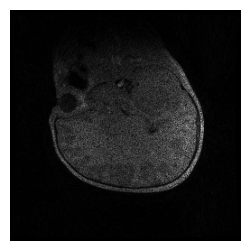

<Figure size 640x480 with 0 Axes>

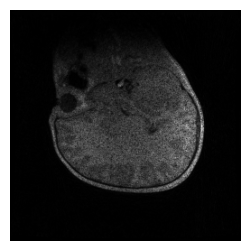

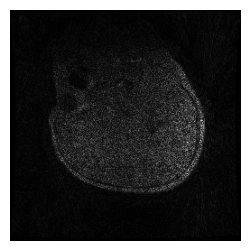

In [43]:
n = 100
c = 0

plt.gray()
plt.figure(figsize=(3,3))
plt.axis('off')
plt.imshow(np.abs(acc[c,:,n,:]))
plt.show()

plt.gray()
plt.figure(figsize=(3,3))
plt.axis('off')
plt.imshow(np.abs(denoised[c,:,n,:]))
plt.show()

plt.figure(figsize=(3,3))
plt.axis('off')
plt.imshow(np.abs((acc-denoised)[c,:,n,:]))
plt.show()

<Figure size 640x480 with 0 Axes>

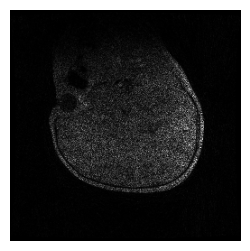

In [28]:


std = 0.5
noisyV = full*(1+complexnoise(full.shape, std))
noisy = noisyV[c,:,n,:]

plt.gray()
plt.figure(figsize=(3,3))
plt.axis('off')
plt.imshow(np.abs(sliced-noisy))
plt.show()